# Dev for leg leaving Titan and Saturn system

In [31]:
import numpy as np
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import spiceypy as spice
import datetime
from cmocean import cm

%matplotlib notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [308]:
sys.path.append("../../polaris/polaris")
import Keplerian as kep
import Propagator as prop

In [245]:
SMA_TITAN = 1221914042.5450587
SOI_SATURN = 54.5e9   # m
vinf_req = 3400.0     # m/s required v-inf to enter/leave Saturn system
energy_req = vinf_req**2/2

V_TITAN = np.sqrt(pxp.MU_SATURN/SMA_TITAN)

In [246]:
def energy_to_velocity(rp, energy, mu):
    vp = np.sqrt(2*(energy + mu/rp))
    return vp

https://nssdc.gsfc.nasa.gov/planetary/factsheet/saturnfact.html
    
Scale height: 59.5 km

In [247]:
def coordinates_hyperbolic(ta, mu, h, e, r_closeby, ta_threshold=0.96):
    """Plot hyperbolic trajectory"""
    if ta > 0:
        tas = np.linspace(ta, -np.pi*ta_threshold, 100)
    else:
        tas = np.linspace(ta, np.pi*ta_threshold, 100)
        
    ephem = np.zeros((6,1))
    ephem_new = np.zeros((6,1))
    for idx, ta in enumerate(tas):
        radius_orbit = h**2/mu * 1/(1 + e*np.cos(ta))
        # store
        if idx == 0:
            ephem[0:3,0] = radius_orbit * np.array([
                np.cos(ta), np.sin(ta), 0.0
            ])
            ephem[3:6,0] = mu/h * np.array([
                -np.sin(ta), e + np.cos(ta), 0.0
            ])
        else:
            # check if x-axis flipped
            xprev = ephem[0,-1]
            ephem_new[0:3,0] = radius_orbit * np.array([
                np.cos(ta), np.sin(ta), 0.0
            ])
            ephem_new[3:6,0] = mu/h * np.array([
                -np.sin(ta), e + np.cos(ta), 0.0
            ])
            xnew = ephem_new[0,0]
            if np.linalg.norm(ephem_new[0:3,0]) < r_closeby or xnew < xprev:  #xnew*xprev > 0 or 
                ephem = np.concatenate((ephem, ephem_new), axis=1)
            else:
                break
    return ephem

In [248]:
def compute_fpa_flyby(mu, rp, vp, r):
    """Get FPA angle after fly-by from hyperbolic rp, vp"""
    # compute elements
    energy = vp**2/2 - mu/rp
    h = rp*vp
    e = np.sqrt(1 + 2*energy*h**2/mu**2)
    theta = np.arccos( (1/e) * (h**2/(r*mu) - 1) )
    # compute radial and tangential velocities
    vt = mu/h * (1 + e*np.cos(theta))
    vr = mu/h * e*np.sin(theta)
    fpa = np.arctan(vr/vt)
    return energy, h, e, theta, fpa, vt, vr

In [249]:
def turn_angle(mu_fb, rp_fb, vinf):
    """Compute turn-angle coerresponding to flyby rp and vinf"""
    delta = 2*np.arcsin(
        (rp_fb*vinf**2 / mu_fb + 1)**(-1)
    )
    return delta

In [258]:
def hyperbolic_time_ode(mu, r, v, r_stop, tof_max):
    """Propagate hyperbolic orbit until r_stop"""
    # create event function
    def stop_at_radius(t, state, mu):
        return np.linalg.norm(state[0:3]) - r_stop
    stop_at_radius.terminal = True
    propout = prop.propagate_twobody(
        mu, np.concatenate((r,v)), tf=tof_max, t0=0.0, events=(stop_at_radius,), steps=4000
    )
    return propout.eventTimes[0][0], propout

In [270]:
flyby_altitudes = np.linspace(2660e3, pxp.R_SATURN*18, 100) # m
vps_saturn = np.zeros(len(flyby_altitudes),)
vs_titan = np.zeros(len(flyby_altitudes),)

fpa_info = np.zeros((5,len(flyby_altitudes)))
ephems_hyperbolic = []
energy_titan = []
times_to_escape = []
turn_angle_max = []

vinfs = []

for idx, alt in tqdm(enumerate(flyby_altitudes), total=len(flyby_altitudes)):
    vps_saturn[idx] = energy_to_velocity(pxp.R_SATURN + alt, energy_req, pxp.MU_SATURN)
    vs_titan[idx]   = energy_to_velocity(SMA_TITAN, energy_req, pxp.MU_SATURN)
    #try:
    rp = pxp.R_SATURN + alt
    vp = energy_to_velocity(pxp.R_SATURN + alt, energy_req, pxp.MU_SATURN)
    energy, h, e, theta, fpa, vt, vr = compute_fpa_flyby(
        pxp.MU_SATURN, 
        rp,
        vp,
        SMA_TITAN,
    )
    
    # compute time-spent on hyperbolic orbit
    r_sc = SMA_TITAN * np.array([np.cos(theta), np.sin(theta), 0.0]) # in m
    alpha = (np.pi/2 - theta) + fpa  # radians
    v_sc = np.sqrt(vt**2 + vr**2) * np.array([-np.cos(alpha), np.sin(alpha), 0.0]) # in m/s
    tof, propout = hyperbolic_time_ode(
        pxp.MU_SATURN, r_sc, v_sc, SOI_SATURN, tof_max=-300*86400.0
    )
    
    if np.isnan(tof) == False and np.abs(fpa) > 0.01:
        times_to_escape.append(tof)

        # store
        fpa_info[:,idx] = energy, h, e, theta, fpa
        vinfs.append(np.sqrt(vr**2 + (vt-V_TITAN)**2))  # assuming titan velocity is circular

        # compute energy with respect to Titan at encounter
        energy_titan.append( (vr**2 + (vt-V_TITAN)**2)/2 )

        # compute and store ephemeris of spacecraft
        ephems_hyperbolic.append(propout)
        
        # compute max turn
        turn_angle_max.append(
            turn_angle(pxp.MU_TITAN, pxp.R_TITAN+1500e3, vinf=vr)
        )
    else:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


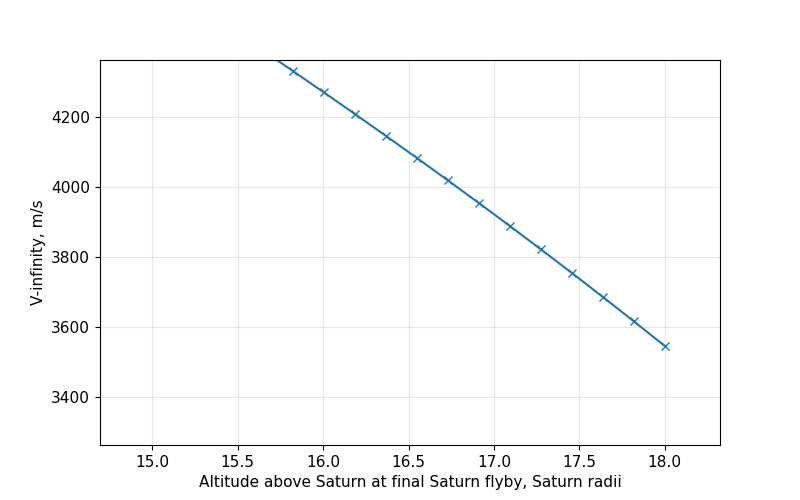

In [271]:
plt.rcParams["font.size"] = 11

fig, ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(flyby_altitudes/pxp.R_SATURN, vinfs, marker="x")
ax.set(
    xlabel="Altitude above Saturn at final Saturn flyby, Saturn radii",
    ylabel="V-infinity, m/s",
)

ax.set_xscale('linear')
ax.grid(True, alpha=0.3)

plt.show()

In [292]:
flyby_altitudes[91]/pxp.R_SATURN

16.549021106398158

In [301]:
# comb = np.concatenate(
#     (
#         self.times.reshape(-1,1), 
#         self.xs.reshape(-1,1)
#         self.ys.reshape(-1,1)
#         self.zs.reshape(-1,1)
#         self.vxs.reshape(-1,1)
#         self.vys.reshape(-1,1)
#         self.vzs.reshape(-1,1)
#     ), 
#     axis=1
# )
# np.save("./dat_hyperbolic_approach/nominal_hyperbolic", comb)

array([[ 0.00000000e+00],
       [-6.48162041e+03],
       [-1.29632408e+04],
       ...,
       [-1.38512228e+07],
       [-1.38577044e+07],
       [-1.38641860e+07]])

In [307]:
ephems_hyperbolic[91].save_to_npy("./dat_hyperbolic_approach/nominal_hyperbolic")
# np.concatenate((ephems_hyperbolic[91].times.reshape(-1,1), ephems_hyperbolic[91].xs.reshape(-1,1)), axis=1).shape

Saved data at ./dat_hyperbolic_approach/nominal_hyperbolic


In [284]:
# plt.rcParams["font.size"] = 11

# fig, ax = plt.subplots(1,1, figsize=(8,5))

# ax.plot(flyby_altitudes/pxp.R_SATURN, fpa_info[4,:]*180/np.pi, marker="x")
# ax.set(
#     xlabel="Altitude above Saturn at final Saturn flyby, Saturn radii",
#     ylabel="FPA w.r.t. Titan, deg",
# )

# ax.set_xscale('linear')
# ax.grid(True, alpha=0.3)

# plt.show()

In [274]:
titan_orbit = pxp.get_circle_coordinates(SMA_TITAN, [0.0,0.0])

In [275]:
min(energy_titan)/1e6

6.287652396134194

In [276]:
np.sqrt(
    2*(vinf_req**2/2 + pxp.MU_SATURN/SMA_TITAN)
)

8582.555118174343

<IPython.core.display.Javascript object>


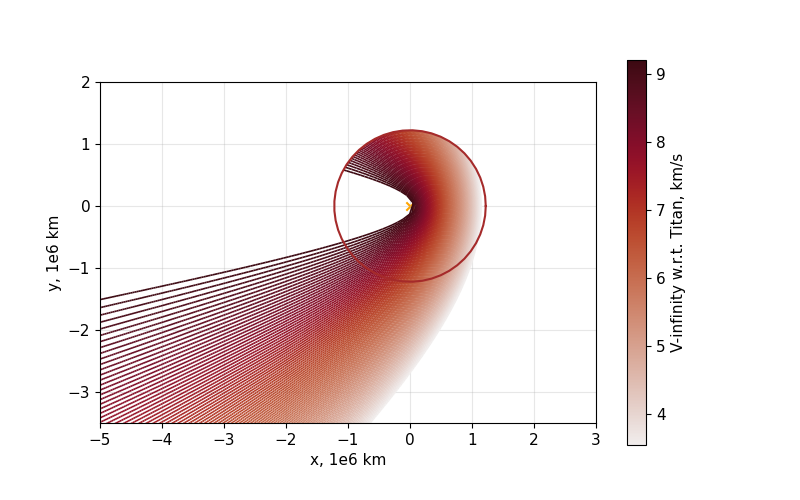

In [280]:
plt.rcParams["font.size"] = 11
lscale = 1/1e9

fig, ax = plt.subplots(1,1, figsize=(8,5))

for idx,eph in enumerate(ephems_hyperbolic):
    #ax.plot(eph[0,:]*lscale, eph[1,:]*lscale)
    
    lc = pxp.get_lc_traj_singleColor(
        xs=eph.xs*lscale, ys=eph.ys*lscale,
        c=vinfs[idx]/1e3, vmin=min(vinfs)/1e3, vmax=max(vinfs)/1e3, cmap=cm.amp, lw=1.2
    )
    line = ax.add_collection(lc)
    

ax.scatter(0, 0, marker="x", c="orange", label="Saturn")
ax.plot(titan_orbit[0,:]*lscale, titan_orbit[1,:]*lscale, c="brown", label="Titan orbit")

ax.set(
    xlabel="x, 1e6 km",
    ylabel="y, 1e6 km",
)

ax.set_xlim([-5, 3])
ax.set_ylim([-3.5, 2])

# display colorbar
fig.colorbar(line, ax=ax, label="V-infinity w.r.t. Titan, km/s")

ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

fig.savefig("./plots/saturn_hyperbolic_vinf_titan.png")

plt.show()

<IPython.core.display.Javascript object>


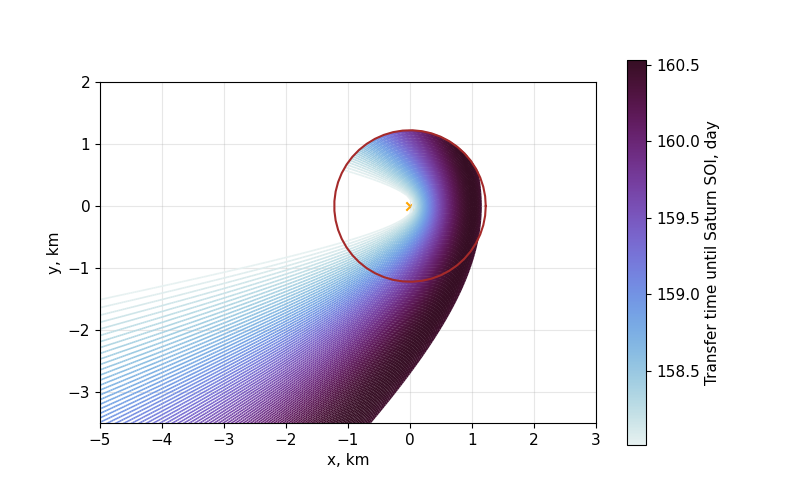

In [283]:
plt.rcParams["font.size"] = 11

fig, ax = plt.subplots(1,1, figsize=(8,5))

for idx,eph in enumerate(ephems_hyperbolic):
    #ax.plot(eph[0,:]*lscale, eph[1,:]*lscale)
    
    lc = pxp.get_lc_traj_singleColor(
        xs=eph.xs*lscale, ys=eph.ys*lscale, 
        c=np.abs(times_to_escape[idx])/86400, vmin=np.abs(max(times_to_escape))/86400,
        vmax=np.abs(min(times_to_escape))/86400, cmap=cm.dense, lw=1.2
    )
    line = ax.add_collection(lc)
    

ax.scatter(0, 0, marker="x", c="orange", label="Saturn")
ax.plot(titan_orbit[0,:]*lscale, titan_orbit[1,:]*lscale, c="brown", label="Titan orbit")

ax.set(
    xlabel="x, km",
    ylabel="y, km",
)

ax.set_xlim([-5, 3])
ax.set_ylim([-3.5, 2])
# display colorbar
fig.colorbar(line, ax=ax, label="Transfer time until Saturn SOI, day")

ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

fig.savefig("./plots/saturn_hyperbolic_tof.png")

plt.show()

<IPython.core.display.Javascript object>


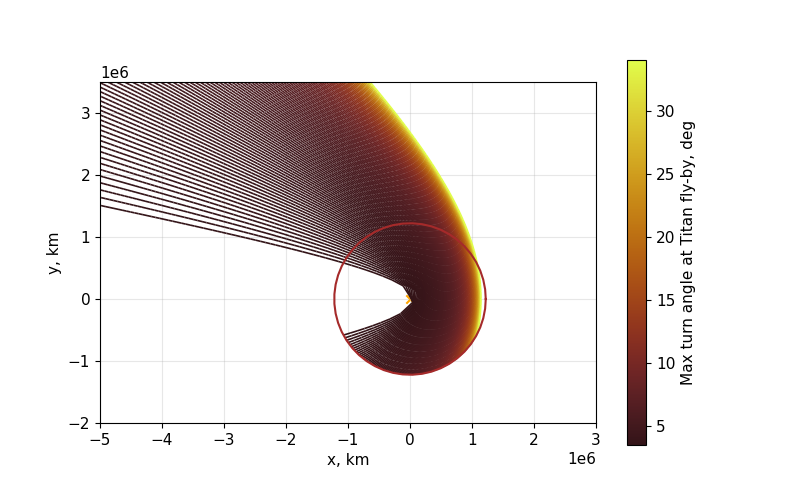

In [241]:
# plt.rcParams["font.size"] = 11
# lscale = 1/1e3

# fig, ax = plt.subplots(1,1, figsize=(8,5))

# for idx,eph in enumerate(ephems_hyperbolic):
#     #ax.plot(eph[0,:]*lscale, eph[1,:]*lscale)
    
#     lc = pxp.get_lc_traj_singleColor(
#         xs=eph.xs*lscale, ys=eph.ys*lscale,
#         c=turn_angle_max[idx]*180/np.pi, vmin=min(turn_angle_max)*180/np.pi,
#         vmax=max(turn_angle_max)*180/np.pi, cmap=cm.solar, lw=1.2
#     )
#     line = ax.add_collection(lc)
    

# ax.scatter(0, 0, marker="x", c="orange", label="Saturn")
# ax.plot(titan_orbit[0,:]*lscale, titan_orbit[1,:]*lscale, c="brown", label="Titan orbit")

# ax.set(
#     xlabel="x, km",
#     ylabel="y, km",
# )

# ax.set_xlim([-5e6, 3e6])
# ax.set_ylim([-2e6, 3.5e6])

# # display colorbar
# fig.colorbar(line, ax=ax, label="Max turn angle at Titan fly-by, deg")

# ax.set_aspect('equal')
# ax.grid(True, alpha=0.3)

# plt.show()

In [242]:
# plt.rcParams["font.size"] = 11
# lscale = 1/1e3

# fig, ax = plt.subplots(1,1, figsize=(8,5))

# for idx,eph in enumerate(ephems_hyperbolic):
#     #ax.plot(eph[0,:]*lscale, eph[1,:]*lscale)
    
#     lc = pxp.get_lc_traj_singleColor(
#         xs=eph.xs*lscale, ys=eph.ys*lscale,
#         c=energy_titan[idx]/1e6, vmin=min(energy_titan)/1e6, vmax=max(energy_titan)/1e6, cmap=cm.deep, lw=1.2
#     )
#     line = ax.add_collection(lc)
    

# ax.scatter(0, 0, marker="x", c="orange", label="Saturn")
# ax.plot(titan_orbit[0,:]*lscale, titan_orbit[1,:]*lscale, c="brown", label="Titan orbit")

# ax.set(
#     xlabel="x, km",
#     ylabel="y, km",
# )

# ax.set_xlim([-5e6, 3e6])
# ax.set_ylim([-2e6, 3.5e6])

# # display colorbar
# fig.colorbar(line, ax=ax, label="Energy w.r.t. Titan, km^2/s^2")

# ax.set_aspect('equal')
# ax.grid(True, alpha=0.3)

# plt.show()